<a href="https://colab.research.google.com/github/ulissigroup/Enabling-Robust-Offline-Active-Learning-for-MLPs/blob/master/Figure_1c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install  -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q --upgrade dftbook
import dftbook
dftbook.setup_colab()

     |████████████████████████████████| 296kB 2.7MB/s 
     |████████████████████████████████| 6.7MB 8.9MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 2.1MB 49.1MB/s 
     |████████████████████████████████| 12.8MB 335kB/s 
     |████████████████████████████████| 110.5MB 100kB/s 
     |████████████████████████████████| 512kB 26.5MB/s 
     |████████████████████████████████| 3.8MB 49.1MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ... do

In [ ]:
!pip install amp-atomistics

     |████████████████████████████████| 102kB 2.3MB/s 
  Created wheel for amp-atomistics: filename=amp_atomistics-0.6.1-cp36-cp36m-linux_x86_64.whl size=396823 sha256=0732a953af8dcff395a862dfdcd37f27b9442f4e5277105ed68c9755b6018358
  Stored in directory: /root/.cache/pip/wheels/47/d6/45/58abd238ea8c11658b0a5ab89b2921baee491e049a7c204b21
Successfully built amp-atomistics


In [ ]:
import os
import sys
import numpy as np
import random
import torch
import copy
import pandas as pd

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.optimize import BFGS, BFGSLineSearch
from ase.eos import EquationOfState
from ase.build import bulk
from ase import Atoms, Atom

from amptorch.active_learning.atomistic_methods import MDsimulate, Relaxation
from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty
from amptorch.active_learning.al_utils import progressive_plot
from amptorch.model import CustomMSELoss

import multiprocessing as mp
from espresso import Espresso

In [ ]:
base_calc = Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE')
base_calc = EMT()
slab = ase.io.read("slab.traj")
# slab.set_calculator(EMT())
training_images = [slab]

ML-only Relaxation

In [ ]:
torch.manual_seed(487238)
for i in range(10):
  file_dir = "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/ml_physics/"
  os.makedirs(file_dir, exist_ok=True)

  # Define symmetry functions
  Gs = {}
  Gs["G2_etas"] = [0.005, 4.0, 20.0, 80.0]
  Gs["G2_rs_s"] = [0] * 4
  Gs["G4_etas"] = [0.005]
  Gs["G4_zetas"] = [1.0, 4.0]
  Gs["G4_gammas"] = [+1.0, -1]
  Gs["cutoff"] = 6.0

  ml_training_params = {
        "al_convergence": {"method": "iter", "num_iterations": 0},
        "samples_to_retrain": 1,
        "Gs": Gs,
        "morse": False,
        "forcetraining": True,
        "cores": 10,
        "optimizer": torch.optim.LBFGS,
        "batch_size": 1000,
        "criterion": CustomMSELoss,
        "num_layers": 3,
        "num_nodes": 20,
        "force_coefficient": 0.04,
        "learning_rate": 1e-2,
        "epochs": 300,
        "test_split": 0,
        "shuffle": False,
        "verbose": 0,
        "filename": f"ml_relax_emt_{i+1}",
        "scheduler": {"policy": None, "params": None},
        "file_dir": file_dir
  }

  # Define AL scheme
  learner = AtomisticActiveLearner(
      training_data=training_images,
      training_params=ml_training_params,
      parent_calc=base_calc,
      ensemble=False
  )
  # Learn the corresponding atomistic method
  learner.learn(
      atomistic_method=Relaxation(
          initial_geometry=slab,
          optimizer=BFGS,
          fmax=0.01,
          steps=200,
      ),
      query_strategy=random_query
  )

Calculating fingerprints...
Fingerprints Calculated!


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


      Step     Time          Energy         fmax
BFGS:    0 01:27:25        6.250355        1.2910
BFGS:    1 01:27:25        6.213663        1.3456
BFGS:    2 01:27:25        6.129136        1.4126
BFGS:    3 01:27:25        6.043604        1.3634
BFGS:    4 01:27:25        5.966550        1.1726
BFGS:    5 01:27:25        5.906953        0.8787
BFGS:    6 01:27:25        5.868564        0.5790
BFGS:    7 01:27:25        5.846752        0.4039
BFGS:    8 01:27:25        5.829842        0.4446
BFGS:    9 01:27:25        5.806449        0.6731
BFGS:   10 01:27:25        5.769331        0.9575
BFGS:   11 01:27:26        5.718419        1.1856
BFGS:   12 01:27:26        5.657457        1.3124
BFGS:   13 01:27:26        5.591526        1.3392
BFGS:   14 01:27:26        5.525237        1.2854
BFGS:   15 01:27:26        5.462107        1.1774
BFGS:   16 01:27:26        5.404263        1.0432
BFGS:   17 01:27:26        5.352854        0.8996
BFGS:   18 01:27:26        5.308777        0.7477
B

Delta-ML Relaxation

In [ ]:
torch.manual_seed(487238)
for i in range(10):
  file_dir = "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_ml_physics/"
  os.makedirs(file_dir, exist_ok=True)

  # Define symmetry functions
  Gs = {}
  Gs["G2_etas"] = [0.005, 4.0, 20.0, 80.0]
  Gs["G2_rs_s"] = [0] * 4
  Gs["G4_etas"] = [0.005]
  Gs["G4_zetas"] = [1.0, 4.0]
  Gs["G4_gammas"] = [+1.0, -1]
  Gs["cutoff"] = 6.0

  delta_ml_training_params = {
        "al_convergence": {"method": "iter", "num_iterations": 0},
        "samples_to_retrain": 1,
        "Gs": Gs,
        "morse": True,
        "forcetraining": True,
        "cores": 10,
        "optimizer": torch.optim.LBFGS,
        "batch_size": 1000,
        "criterion": CustomMSELoss,
        "num_layers": 3,
        "num_nodes": 20,
        "force_coefficient": 0.04,
        "learning_rate": 1e-2,
        "epochs": 300,
        "test_split": 0,
        "shuffle": False,
        "verbose": 0,
        "filename": f"delta_ml_relax_emt_{i+1}",
        "scheduler": {"policy": None, "params": None},
        "file_dir": file_dir
  }

  # Define AL scheme
  learner = AtomisticActiveLearner(
      training_data=training_images,
      training_params=delta_ml_training_params,
      parent_calc=base_calc,
      ensemble=False
  )
  # Learn the corresponding atomistic method
  learner.learn(
      atomistic_method=Relaxation(
          initial_geometry=slab,
          optimizer=BFGS,
          fmax=0.01,
          steps=200,
      ),
      query_strategy=random_query
  )

Calculating fingerprints...
Fingerprints Calculated!
      Step     Time          Energy         fmax
BFGS:    0 01:32:19        6.250781        1.2913
BFGS:    1 01:32:19        6.219885        1.3198
BFGS:    2 01:32:20        6.162380        1.4193
BFGS:    3 01:32:20        6.112413        1.5235
BFGS:    4 01:32:20        6.061201        1.6416
BFGS:    5 01:32:20        6.019855        1.9473
BFGS:    6 01:32:20        5.938097        1.8943
BFGS:    7 01:32:20        5.849113        2.0864
BFGS:    8 01:32:20        5.751750        2.3230
BFGS:    9 01:32:20        5.644386        2.6221
BFGS:   10 01:32:21        5.524639        2.9941
BFGS:   11 01:32:21        5.390110        3.4306
BFGS:   12 01:32:21        5.238817        3.9136
BFGS:   13 01:32:21        5.069215        4.4114
BFGS:   14 01:32:21        4.880896        4.8909
BFGS:   15 01:32:21        4.656808        5.3546
BFGS:   16 01:32:21        4.433079        5.7381
BFGS:   17 01:32:21        4.195174        6.061

In [ ]:
ml_dir = '/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/ml_physics/'
delta_ml_dir = '/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_ml_physics/'

In [ ]:
def short_distance(images):
  shortest_distances = []
  for image in images:
    image_distances = []
    for idx in range(len(image)):
      indices = np.arange(len(image))
      indices = np.delete(indices, idx)
      distances = image.get_distances(idx, indices)
      image_distances.append(min(distances))
    shortest_distances.append(min(image_distances))
  return shortest_distances

def con_dataframe(file_dir, name, trials):
  trial_name = f'{file_dir}{name}_1_iter_0.traj'
  images = ase.io.read(trial_name, ':')
  image_distances = short_distance(images)
  base_frame = pd.DataFrame({
      'step': range(len(images)),
      'distance': image_distances
  })
  for i in range(1, trials):
    trial_name = f'{file_dir}{name}_{i+1}_iter_0.traj'
    images = ase.io.read(trial_name, ':')
    image_distances = short_distance(images)
    frame = pd.DataFrame({
        'step': range(len(images)),
        'distance': image_distances
    })
    base_frame = base_frame.append(frame)
  
  return base_frame

In [ ]:
ml_distances = con_dataframe(ml_dir, 'ml_relax_emt', 10)
delta_ml_distances = con_dataframe(delta_ml_dir, 'delta_ml_relax_emt', 10)
# true_distances = short_distance(ase.io.read('./true_relax.traj', ':'))

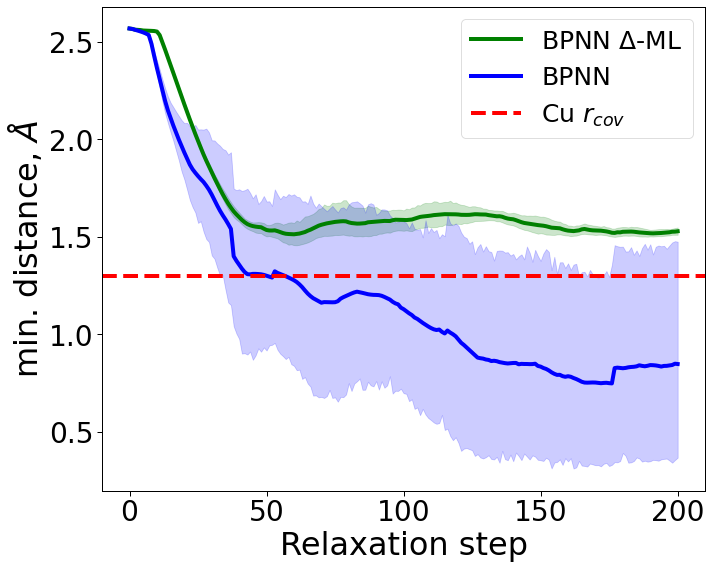

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(10,8))
sns.set_context("paper")
colors = ["green", "blue", "black"]
sns.set_palette(colors)
graph = sns.lineplot(x='step', y='distance', data=delta_ml_distances, linewidth=4, label='BPNN $\Delta$-ML')
ax = sns.lineplot(x='step', y='distance', data=ml_distances, linewidth=4, label='BPNN')
ax.axhline(y=1.3, color='r', linestyle='--', linewidth=4, label="Cu $r_{cov}$")
plt.ylabel('min. distance, $\AA$', fontsize=32)
plt.xlabel('Relaxation step', fontsize=32)
plt.tick_params(axis="both", labelsize=28)
plt.legend(fontsize=25)
plt.tight_layout()
plt.savefig(f'{delta_ml_dir}shortest_distances.png', dpi=300)